In [69]:
import pandas as pd
import numpy as np
from plotly.graph_objs import *
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from read_bucket import ReadDataFrame
# Data Visualization using plotly
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "vscode"
pio.renderers.default = "svg"
init_notebook_mode(connected=True)

In [70]:
r = ReadDataFrame(bucket_name='estac-data', file_name='estac_data.csv')

In [71]:
data = r.read_dataframe()

Fetching file from s3://estac-data/estac_data.csv
Loaded 159070 records from s3://estac-data/estac_data.csv


In [72]:
past_record = pd.read_csv('estac_data.csv')

In [73]:
combined_df = pd.concat([past_record,data], ignore_index=True)

In [74]:
df = combined_df.drop_duplicates(subset=['device_time'],keep='last')

In [75]:
df.shape

(194881, 3)

In [76]:
df.tail()

,device_time,humidity,temperature
194879,2025-11-18 13:30:19,38.1,25.9
194880,2025-11-18 13:31:06,38.5,25.7
194881,2025-11-18 13:31:24,38.6,25.7
194882,2025-11-18 13:31:39,38.7,25.6
194883,2025-11-18 13:32:35,39.1,25.5


In [77]:
df['device_time'] = pd.to_datetime(df['device_time'])

C:\Users\manek\AppData\Local\Temp\ipykernel_21236\2466456670.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
df['hour'] = df['device_time'].dt.hour

C:\Users\manek\AppData\Local\Temp\ipykernel_21236\1669095676.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
# df.to_csv("estac_records.csv", index=False)

In [80]:

df.set_index('device_time', inplace=True)

In [81]:
df.head()

,humidity,temperature,hour
device_time,,,
2025-10-05 00:05:20,80.9,27.0,0
2025-10-05 00:05:33,80.9,27.0,0
2025-10-05 00:05:47,80.9,27.0,0
2025-10-05 00:06:00,80.9,27.0,0
2025-10-05 00:06:14,80.9,27.0,0


In [82]:
# Resample hourly
hourly = df.resample('h').mean()

In [83]:
hourly = hourly.reset_index()

In [84]:
hourly = hourly.dropna()

In [85]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981 entries, 0 to 1069
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   device_time  981 non-null    datetime64[ns]
 1   humidity     981 non-null    float64       
 2   temperature  981 non-null    float64       
 3   hour         981 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 38.3 KB


In [86]:
hourly['temperature'] = hourly['temperature'].round(1)
hourly['humidity'] = hourly['humidity'].round(1)


In [87]:
hourly['hour'] = hourly['hour'].astype(int)

In [88]:
# Rolling averages (smooth short-term fluctuations)
hourly['Temp_MA_2'] = hourly['temperature'].rolling(window=2).mean()
hourly['Humidity_MA_2'] = hourly['humidity'].rolling(window=2).mean()

In [89]:
# Rate of change (trend direction and strength)
hourly['Temp_rate'] = hourly['Temp_MA_2'].diff()
hourly['Humidity_rate'] = hourly['Humidity_MA_2'].diff()

In [90]:
def classify_phases(
    df, 
    temp_rate_col="Temp_rate", 
    humidity_rate_col="Humidity_rate",
    threshold=1.5,
    temp_phase_col="Temp_phase",
    humidity_phase_col="Humidity_phase"
):
    """
    Classify Heating/Cooling and Moistening/Drying phases in a dataframe.

    Parameters
    ----------
    df : pandas DataFrame
        Input dataframe.

    temp_rate_col : str
        Column name containing temperature rate values.

    humidity_rate_col : str
        Column name containing humidity rate values.

    threshold : float
        Rate threshold for detecting meaningful changes.

    temp_phase_col : str
        Output column name for temperature phase labels.

    humidity_phase_col : str
        Output column name for humidity phase labels.

    Returns
    -------
    df : pandas DataFrame
        DataFrame with two new columns: temp_phase_col and humidity_phase_col.
    """

    # Temperature phases
    df[temp_phase_col] = np.where(
        df[temp_rate_col] > threshold, "Heating",
        np.where(df[temp_rate_col] < -threshold, "Cooling", "Neutral")
    )

    # Humidity phases
    df[humidity_phase_col] = np.where(
        df[humidity_rate_col] > threshold, "Moistening",
        np.where(df[humidity_rate_col] < -threshold, "Drying", "Moderate")
    )

    return df

In [91]:
identify_phase = classify_phases(df=hourly, threshold=0.05)

In [92]:
hourly

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase
0,2025-10-05 00:00:00,81.0,27.0,0,NaN,NaN,NaN,NaN,Neutral,Moderate
1,2025-10-05 01:00:00,81.3,27.0,1,27.0,81.15,NaN,NaN,Neutral,Moderate
2,2025-10-05 02:00:00,81.6,27.0,2,27.0,81.45,0.00,0.30,Neutral,Moistening
3,2025-10-05 03:00:00,81.8,27.0,3,27.0,81.70,0.00,0.25,Neutral,Moistening
4,2025-10-05 04:00:00,82.0,27.0,4,27.0,81.90,0.00,0.20,Neutral,Moistening
...,...,...,...,...,...,...,...,...,...,...
1065,2025-11-18 09:00:00,43.5,26.1,9,26.2,45.35,-0.25,-3.90,Cooling,Drying
1066,2025-11-18 10:00:00,44.6,25.7,10,25.9,44.05,-0.30,-1.30,Cooling,Drying
1067,2025-11-18 11:00:00,43.8,25.5,11,25.6,44.20,-0.30,0.15,Cooling,Moistening
1068,2025-11-18 12:00:00,41.9,24.9,12,25.2,42.85,-0.40,-1.35,Cooling,Drying


In [93]:
def daytime_labels(hour):
    """Return a label describing the time of day based on hour (0–23)."""

    # validate input
    if hour is None:
        return None
    try:
        hour = float(hour)
    except ValueError:
        return None

    ranges = [
        ((0, 3),  'late night'),
        ((3, 6),  'early morning'),
        ((6, 12), 'morning'),
        ((12, 15),'afternoon'),
        ((15, 21),'evening'),
        ((21, 24),'night')
    ]

    for (low, high), label in ranges:
        if low <= hour <= high:
            return label

    return None  # hour outside expected range


hourly['daytime_labels'] = hourly['hour'].apply(daytime_labels)

In [94]:
hourly.head()

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase,daytime_labels
0,2025-10-05 00:00:00,81.0,27.0,0,NaN,NaN,NaN,NaN,Neutral,Moderate,late night
1,2025-10-05 01:00:00,81.3,27.0,1,27.0,81.15,NaN,NaN,Neutral,Moderate,late night
2,2025-10-05 02:00:00,81.6,27.0,2,27.0,81.45,0.0,0.30,Neutral,Moistening,late night
3,2025-10-05 03:00:00,81.8,27.0,3,27.0,81.70,0.0,0.25,Neutral,Moistening,late night
4,2025-10-05 04:00:00,82.0,27.0,4,27.0,81.90,0.0,0.20,Neutral,Moistening,early morning


In [95]:
hourly['Temp_group'] = (hourly['Temp_phase'] != hourly['Temp_phase'].shift()).cumsum()
hourly['Humidity_group'] = (hourly['Humidity_phase'] != hourly['Humidity_phase'].shift()).cumsum()


In [96]:
# Quantify each phase
temp_cycles = identify_phase.groupby('Temp_group').agg(
    phase=('Temp_phase', 'first'),
    start_time=('device_time', 'min'),
    end_time=('device_time', 'max'),
    start=('Temp_MA_2', 'first'),

    end=('Temp_MA_2', 'last'),
    duration=('temperature', 'count')
)

temp_cycles['delta'] = temp_cycles['end'] - temp_cycles['start']
temp_cycles['rate'] = temp_cycles['delta'] / temp_cycles['duration']

In [97]:
# Quantify each humidity phase
humidity_cycles = identify_phase.groupby('Humidity_group').agg(
    phase=('Humidity_phase', 'first'),
    start_time=('device_time', 'min'),
    end_time=('device_time', 'max'),
    start=('Humidity_MA_2', 'first'),     # starting moving-average humidity
    end=('Humidity_MA_2', 'last'),        # ending moving-average humidity
    duration=('humidity', 'count')        # number of data points in the phase
)

humidity_cycles['delta'] = humidity_cycles['end'] - humidity_cycles['start']
humidity_cycles['rate']  = humidity_cycles['delta'] / humidity_cycles['duration']


In [98]:
temp_cycles.isnull().sum()

phase         0
start_time    0
end_time      0
start         0
end           0
duration      0
delta         0
rate          0
dtype: int64

In [99]:
temp_cycles = temp_cycles[(temp_cycles['phase'] != 'Neutral') & (temp_cycles['duration'] > 1)]


In [100]:
hourly.to_csv("hourly_summary.csv",index=False)

In [101]:
temp_cycles

,phase,start_time,end_time,start,end,duration,delta,rate
Temp_group,,,,,,,,
2,Heating,2025-10-05 06:00:00,2025-10-05 07:00:00,27.05,27.10,2,0.05,0.025000
4,Heating,2025-10-05 09:00:00,2025-10-05 11:00:00,27.25,27.90,3,0.65,0.216667
5,Cooling,2025-10-05 12:00:00,2025-10-05 17:00:00,27.80,24.25,6,-3.55,-0.591667
6,Heating,2025-10-05 18:00:00,2025-10-06 00:00:00,25.15,26.85,7,1.70,0.242857
8,Heating,2025-10-06 02:00:00,2025-10-06 03:00:00,26.95,27.00,2,0.05,0.025000
...,...,...,...,...,...,...,...,...
311,Cooling,2025-11-17 00:00:00,2025-11-17 01:00:00,27.55,27.50,2,-0.05,-0.025000
313,Cooling,2025-11-17 03:00:00,2025-11-17 04:00:00,27.45,27.40,2,-0.05,-0.025000
317,Cooling,2025-11-17 08:00:00,2025-11-17 13:00:00,26.95,23.90,6,-3.05,-0.508333


In [102]:
humidity_cycles

,phase,start_time,end_time,start,end,duration,delta,rate
Humidity_group,,,,,,,,
1,Moderate,2025-10-05 00:00:00,2025-10-05 01:00:00,81.15,81.15,2,0.00,0.000000
2,Moistening,2025-10-05 02:00:00,2025-10-05 08:00:00,81.45,82.50,7,1.05,0.150000
3,Moderate,2025-10-05 09:00:00,2025-10-05 09:00:00,82.55,82.55,1,0.00,0.000000
4,Drying,2025-10-05 10:00:00,2025-10-05 11:00:00,81.80,80.75,2,-1.05,-0.525000
5,Moistening,2025-10-05 12:00:00,2025-10-05 13:00:00,81.20,81.65,2,0.45,0.225000
...,...,...,...,...,...,...,...,...
279,Drying,2025-11-17 11:00:00,2025-11-17 14:00:00,50.45,44.40,4,-6.05,-1.512500
280,Moistening,2025-11-17 15:00:00,2025-11-18 03:00:00,46.35,53.65,13,7.30,0.561538
281,Drying,2025-11-18 04:00:00,2025-11-18 10:00:00,53.45,44.05,7,-9.40,-1.342857


In [103]:
def plot_corr_heatmap(df, figsize=(10, 8), cmap="coolwarm", annot=True, fmt=".2f", **kwargs):
    """
    Plots a heatmap of the correlation matrix of a dataframe.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe (numeric columns only are recommended)
    figsize : tuple
        Size of the heatmap figure
    cmap : str
        Colormap to use for the heatmap
    annot : bool
        Whether to display correlation values inside each cell
    fmt : str
        Number formatting for annotation text
    **kwargs : dict
        Any additional arguments passed to sns.heatmap()
    """

    # Calculate correlation matrix
    corr = df.corr(numeric_only=True)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        linewidths=0.5,
        square=True,
        **kwargs
    )

    plt.title("Correlation Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()

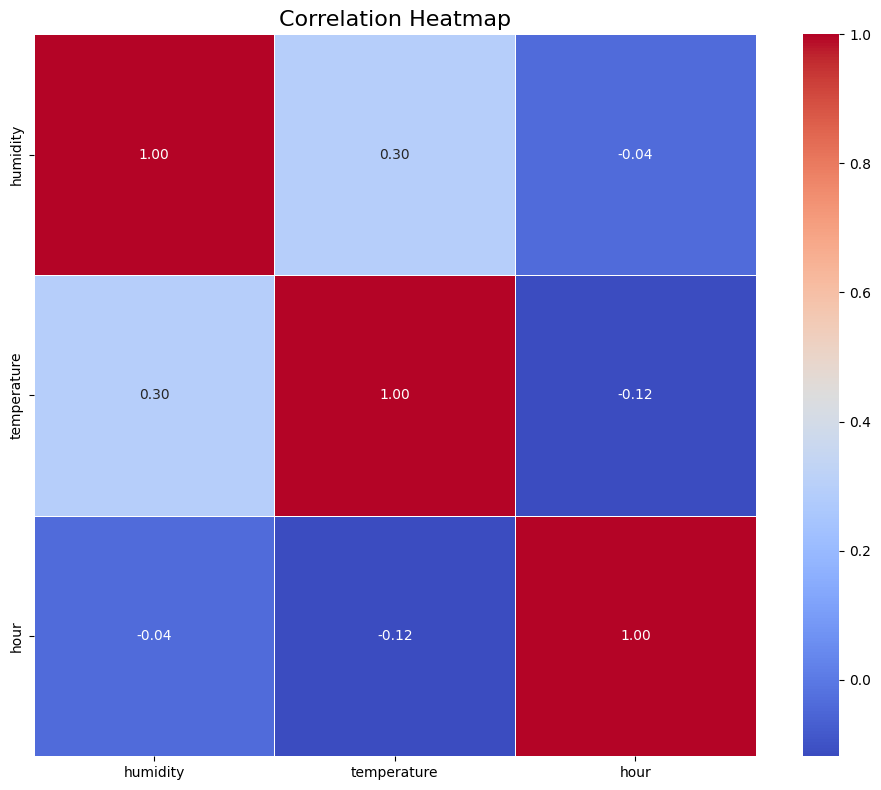

In [104]:
plot_corr_heatmap(df=df)

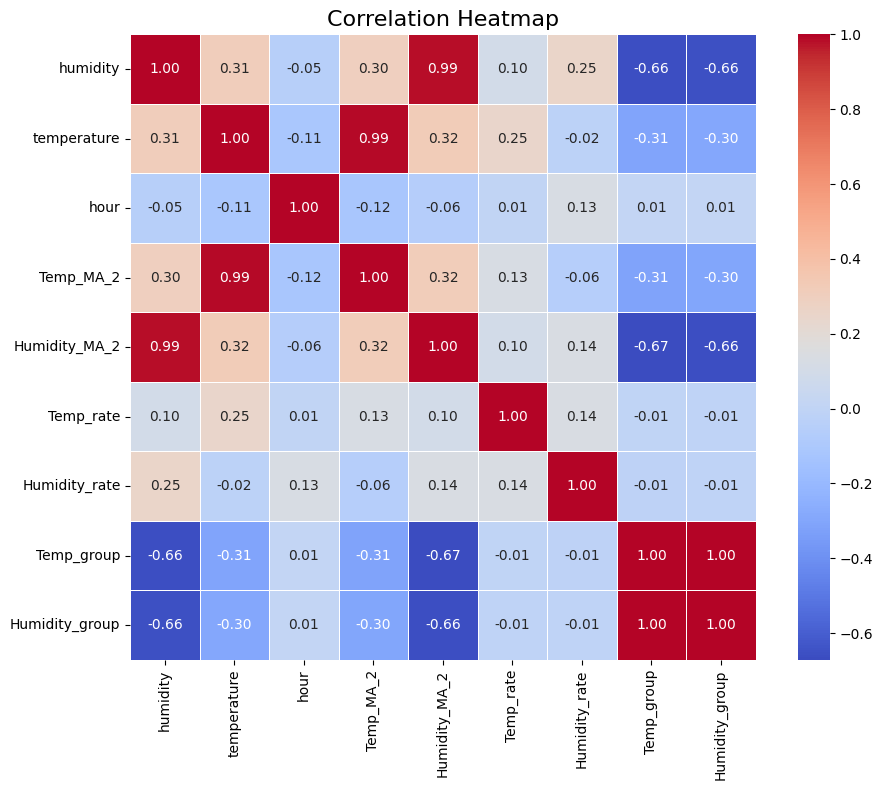

In [105]:
plot_corr_heatmap(df=hourly)

In [106]:
hourly.to_csv("Hourly_summary.csv",index=False)

In [107]:
hourly.value_counts('Temp_phase')

Temp_phase
Heating    393
Cooling    377
Neutral    211
Name: count, dtype: int64

In [108]:
def dual_axis_plot(df, x, y1, y2, **kwargs):
    """
    Creates a dual-axis line chart (Plotly).
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    x : str
        Column for x-axis.
    y1 : str
        Primary y-axis column (left).
    y2 : str
        Secondary y-axis column (right).
    **kwargs :
        title, line colors, axis labels, width, height, template, etc.
    """

    # ---- Defaults if not provided ----
    title = kwargs.get("title", f"{y1} and {y2} vs {x}")
    template = kwargs.get("template", "plotly_white")
    width = kwargs.get("width", 1000)
    height = kwargs.get("height", 500)

    y1_color = kwargs.get("y1_color", "red")     # Default primary axis color
    y2_color = kwargs.get("y2_color", "blue")    # Default secondary axis color

    y1_label = kwargs.get("y1_label", y1)
    y2_label = kwargs.get("y2_label", y2)
    x_label  = kwargs.get("x_label", x)

    # ---- Figure with two y-axes ----
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # ---- Primary axis trace ----
    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y1],
            name=y1,
            line=dict(color=y1_color)
        ),
        secondary_y=False
    )

    # ---- Secondary axis trace ----
    fig.add_trace(
        go.Scatter(
            x=df[x],
            y=df[y2],
            name=y2,
            line=dict(color=y2_color)
        ),
        secondary_y=True
    )

    # ---- Update axes ----
    fig.update_yaxes(
        title_text=f"<b>{y1_label}</b>",
        title_font=dict(color=y1_color),
        secondary_y=False,
        showgrid=False
    )

    fig.update_yaxes(
        title_text=f"<b>{y2_label}</b>",
        title_font=dict(color=y2_color),
        secondary_y=True,
        showgrid=True
    )

    fig.update_xaxes(
        title_text=f"<b>{x_label}</b>",
        showgrid=True
    )

    # ---- Layout ----
    fig.update_layout(
        title=title,
        width=width,
        height=height,
        template=template
    )

    fig.show()

In [109]:
dual_axis_plot(
    df=hourly,
    x="device_time",
    y1="temperature",
    y2="humidity",
    title="Temperature & Humidity Over Time",
    y1_label="Temperature (°C)",
    y2_label="Humidity (%)",
    y1_color="red",
    y2_color="blue",
    template="plotly_white"
)


In [110]:
daytime_aggregation_table = hourly.groupby(['daytime_labels'])[['temperature', 'humidity']].mean()

In [111]:
# Ensure correct order of daytime segments
order = ["late night", "early morning", "morning", "afternoon", "evening", "night"]



# Reset index so daytime_labels becomes a column
df_plot = daytime_aggregation_table.reset_index()

# Sort rows by correct daytime order
df_plot['daytime_labels'] = pd.Categorical(df_plot['daytime_labels'], categories=order, ordered=True)
df_plot = df_plot.sort_values('daytime_labels')

In [112]:


def plot_line_multi(df, x, y, **kwargs):
    """
    Generic Plotly line chart function.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    x : str
        Column to use on x-axis.
    y : list
        List of column names to plot on y-axis.
    **kwargs : 
        Additional parameters like:
        - title
        - width
        - height
        - template
        - line_width
        - marker_size
        ...and anything else for flexibility.
    """
    
    # Defaults (if not provided)
    title = kwargs.get("title", "Line Plot")
    template = kwargs.get("template", "plotly_white")
    width = kwargs.get("width", 900)
    height = kwargs.get("height", 500)
    line_width = kwargs.get("line_width", 3)
    marker_size = kwargs.get("marker_size", 8)

    fig = go.Figure()

    for col in y:
        fig.add_trace(go.Scatter(
            x=df[x],
            y=df[col],
            mode='lines+markers',
            name=col,
            line=dict(width=line_width),
            marker=dict(size=marker_size)
        ))

    fig.update_layout(
        title=title,
        xaxis_title=x,
        yaxis_title="Value",
        template=template,
        width=width,
        height=height
    )

    fig.show()

In [113]:
plot_line_multi(
    df=df_plot,
    x="daytime_labels",
    y=["humidity", "temperature"],
    title="Humidity & Temperature vs Daytime Labels",
    line_width=4,
    marker_size=10,
    template="plotly_white"
)


In [114]:
def plot_dual_axis_rates(
    df, 
    x_col, 
    y1_col, 
    y2_col, 
    **kwargs
):
    """
    Create a dual-axis plot (temperature rate vs humidity rate)
    using Plotly with configurable customization via kwargs.
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe
    x_col : str
        Column for x-axis (time)
    y1_col : str
        Primary y-axis column (Temperature rate)
    y2_col : str
        Secondary y-axis column (Humidity rate)
    **kwargs : dict
        Any extra keyword arguments for customizing:
            - title
            - y1_name
            - y2_name
            - width
            - height
            - line1_color
            - line2_color
            - dash2
    """

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Defaults (overridden by kwargs)
    title = kwargs.get("title", "Temperature & Humidity Rate Over Time")
    y1_name = kwargs.get("y1_name", "Temp Rate (°C/hr)")
    y2_name = kwargs.get("y2_name", "Humidity Rate (%/hr)")
    line1_color = kwargs.get("line1_color", "red")
    line2_color = kwargs.get("line2_color", "blue")
    dash2 = kwargs.get("dash2", "dot")
    width = kwargs.get("width", 1100)
    height = kwargs.get("height", 500)

    # --- Primary Y Axis Trace ---
    fig.add_trace(
        go.Scatter(
            x=df[x_col],
            y=df[y1_col],
            mode="lines",
            name=y1_name,
            line=dict(color=line1_color, width=2),
            hovertemplate="Time: %{x}<br>"+y1_name+": %{y:.2f}<extra></extra>"
        ),
        secondary_y=False
    )

    # --- Secondary Y Axis Trace ---
    fig.add_trace(
        go.Scatter(
            x=df[x_col],
            y=df[y2_col],
            mode="lines",
            name=y2_name,
            line=dict(color=line2_color, width=2, dash=dash2),
            hovertemplate="Time: %{x}<br>"+y2_name+": %{y:.2f}<extra></extra>"
        ),
        secondary_y=True
    )

    # Common Y-range
    y_min = min(df[y1_col].min(), df[y2_col].min())
    y_max = max(df[y1_col].max(), df[y2_col].max())

    # Update axes
    fig.update_yaxes(title_text=y1_name, range=[y_min, y_max], secondary_y=False)
    fig.update_yaxes(title_text=y2_name, range=[y_min, y_max], secondary_y=True)
    fig.update_xaxes(title_text="Time")

    # Horizontal zero lines
    fig.add_hline(y=0, line=dict(color="black", dash="dash"), opacity=0.6, secondary_y=False)
    fig.add_hline(y=0, line=dict(color="grey", dash="dot"), opacity=0.6, secondary_y=True)

    # Layout
    fig.update_layout(
        title=title,
        width=width,
        height=height,
        template="plotly_white"
    )

    fig.show()

In [115]:
plot_dual_axis_rates(
    hourly,
    x_col="device_time",
    y1_col="Temp_rate",
    y2_col="Humidity_rate",
    title="Temperature and Humidity Rate Comparison",
    line1_color="darkred",
    line2_color="blue",
    
)


In [116]:

def plot_ma_with_phase(
    df, 
    x_col, 
    y_col, 
    phase_col, 
    **kwargs
):
    """
    Plot a moving average line + colored markers by Heating/Cooling phase.
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe
    x_col : str
        X-axis column
    y_col : str
        Temperature moving average column
    phase_col : str
        Column with categorical phases (e.g., Heating / Cooling)
    **kwargs : dict
        Optional custom styling such as:
        - title
        - ma_color
        - marker_heating_color
        - marker_cooling_color
        - marker_size
        - width, height
    """

    # Defaults that can be overridden via kwargs
    title = kwargs.get("title", "Temperature MA Colored by Phase")
    ma_color = kwargs.get("ma_color", "green")
    marker_heating_color = kwargs.get("marker_heating_color", "red")
    marker_cooling_color = kwargs.get("marker_cooling_color", "blue")
    marker_size = kwargs.get("marker_size", 6)
    width = kwargs.get("width", 1100)
    height = kwargs.get("height", 500)

    # Map phase colors dynamically
    phase_color_map = {
        'Heating': marker_heating_color,
        'Cooling': marker_cooling_color
    }

    # --- Create figure ---
    fig = go.Figure()

    # 1. MA Line
    fig.add_trace(go.Scatter(
        x=df[x_col],
        y=df[y_col],
        mode='lines',
        name=f"{y_col} (MA)",
        line=dict(color=ma_color, width=1.8)
    ))

    # 2. Markers colored by phase
    fig.add_trace(go.Scatter(
        x=df[x_col],
        y=df[y_col],
        mode='markers',
        name="Phase",
        marker=dict(
            size=marker_size,
            color=df[phase_col].map(phase_color_map),
            line=dict(width=1, color="DarkSlateGrey")
        ),
        customdata=df[[phase_col]].values,
        hovertemplate=(
            "Time: %{x}<br>"
            f"{y_col}: "+"%{y:.2f}<br>"
            f"Phase: "+"%{customdata[0]}<extra></extra>"
        )
    ))

    # Layout
    fig.update_layout(
        title=f"<b>{title}</b>",
        xaxis_title="Time",
        yaxis_title="Temperature (°C)",
        template="plotly_white",
        width=width,
        height=height,
        legend=dict(yanchor="top", y=1.15, xanchor="right", x=0.99)
    )

    fig.show()


In [117]:
plot_ma_with_phase(
    hourly,
    x_col="device_time",
    y_col="Temp_MA_2",
    phase_col="Temp_phase",
    title="Temp MA (2h) – Heating vs Cooling",
    ma_color="green",
    marker_heating_color="crimson",
    marker_cooling_color="royalblue",
    marker_size=7
)



In [118]:
def plot_timeline(data: pd.DataFrame,start_col: str,end_col: str,phase_col: str,color_map: dict,show: bool = False,**kwargs):
    """
    Create a timeline chart showing temperature phases (e.g., Heating/Cooling).

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing start, end, and phase columns.
    start_col : str, default='start_time'
        Column representing the start of each phase.
    end_col : str, default='end_time'
        Column representing the end of each phase.
    phase_col : str, default='phase'
        Column representing the phase category (e.g., Heating, Cooling).
    color_map : dict, optional
        Custom color mapping for phases, e.g., {'Heating':'red', 'Cooling':'blue'}.
    **kwargs :
        Additional keyword arguments forwarded to px.timeline().
        Examples: title, hover_data, height, template, category_orders, etc.

    Returns
    -------
    plotly.graph_objects.Figure
        The Plotly timeline figure.
    """
    try:
        # Default color map if not provided
        if color_map is None:
            color_map = {"Heating": "red", "Cooling": "blue"}

        # Default hover fields
        hover_defaults = {"delta": True, start_col: True, end_col: True}
        hover_data = kwargs.pop("hover_data", hover_defaults)

        fig = px.timeline(
            data,
            x_start=start_col,
            x_end=end_col,
            y=phase_col,
            color=phase_col,
            color_discrete_map=color_map,
            hover_data=hover_data,
            **kwargs
        )

        # Order y-axis (Heating above Cooling)
        fig.update_yaxes(categoryorder="array", categoryarray=["Heating", "Cooling"])

        # Layout customization
        fig.update_layout(
            xaxis_title="Time",
            yaxis_title="Phase Type",
            template=kwargs.pop("template", "plotly_white"),
            height=kwargs.pop("height", 400)
        )

        if show:
            fig.show()
        return fig
    except Exception as e:
        print(f"Error creating temperature timeline: {e}")
        raise

In [119]:
temp_phase_chart = plot_timeline(
    temp_cycles,
    start_col="start_time",
    end_col='end_time',
    phase_col='phase',
    color_map={'Heating': 'red', 'Cooling': 'blue'},
    title="Temperature Phases",
    hover_data={'start_time': True, 'end_time': True, 'delta': True},
    height=500,
    template="simple_white",
    show=False
)

temp_phase_chart.show()



In [120]:
humidit_phase_chart = plot_timeline(
    humidity_cycles,
    start_col="start_time",
    end_col='end_time',
    phase_col='phase',
    color_map={'Drying': 'red', 'Moistening': 'green','Moderate': "blue"},
    title="Humidity Phases",
    hover_data={'start_time': True, 'end_time': True, 'delta': True},
    height=500,
    template="simple_white",
    show=False
)

humidit_phase_chart.show()

In [121]:
temp_cycles.columns

Index(['phase', 'start_time', 'end_time', 'start', 'end', 'duration', 'delta',
       'rate'],
      dtype='object')

In [122]:
temp_cycles

,phase,start_time,end_time,start,end,duration,delta,rate
Temp_group,,,,,,,,
2,Heating,2025-10-05 06:00:00,2025-10-05 07:00:00,27.05,27.10,2,0.05,0.025000
4,Heating,2025-10-05 09:00:00,2025-10-05 11:00:00,27.25,27.90,3,0.65,0.216667
5,Cooling,2025-10-05 12:00:00,2025-10-05 17:00:00,27.80,24.25,6,-3.55,-0.591667
6,Heating,2025-10-05 18:00:00,2025-10-06 00:00:00,25.15,26.85,7,1.70,0.242857
8,Heating,2025-10-06 02:00:00,2025-10-06 03:00:00,26.95,27.00,2,0.05,0.025000
...,...,...,...,...,...,...,...,...
311,Cooling,2025-11-17 00:00:00,2025-11-17 01:00:00,27.55,27.50,2,-0.05,-0.025000
313,Cooling,2025-11-17 03:00:00,2025-11-17 04:00:00,27.45,27.40,2,-0.05,-0.025000
317,Cooling,2025-11-17 08:00:00,2025-11-17 13:00:00,26.95,23.90,6,-3.05,-0.508333


In [123]:
hourly.tail(30)

,device_time,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_phase,Humidity_phase,daytime_labels,Temp_group,Humidity_group
1040,2025-11-17 08:00:00,48.4,26.6,8,26.95,49.10,-0.35,-0.40,Cooling,Drying,morning,317,277
1041,2025-11-17 09:00:00,51.7,25.3,9,25.95,50.05,-1.00,0.95,Cooling,Moistening,morning,317,278
1042,2025-11-17 10:00:00,50.5,25.2,10,25.25,51.10,-0.70,1.05,Cooling,Moistening,morning,317,278
1043,2025-11-17 11:00:00,50.4,24.6,11,24.90,50.45,-0.35,-0.65,Cooling,Drying,morning,317,279
1044,2025-11-17 12:00:00,45.8,24.1,12,24.35,48.10,-0.55,-2.35,Cooling,Drying,morning,317,279
1045,2025-11-17 13:00:00,43.7,23.7,13,23.90,44.75,-0.45,-3.35,Cooling,Drying,afternoon,317,279
1046,2025-11-17 14:00:00,45.1,24.2,14,23.95,44.40,0.05,-0.35,Heating,Drying,afternoon,318,279
1047,2025-11-17 15:00:00,47.6,23.5,15,23.85,46.35,-0.10,1.95,Cooling,Moistening,afternoon,319,280
1048,2025-11-17 16:00:00,47.6,24.3,16,23.90,47.60,0.05,1.25,Neutral,Moistening,evening,320,280
1049,2025-11-17 17:00:00,48.8,24.6,17,24.45,48.20,0.55,0.60,Heating,Moistening,evening,321,280


In [124]:
temp_cycles

,phase,start_time,end_time,start,end,duration,delta,rate
Temp_group,,,,,,,,
2,Heating,2025-10-05 06:00:00,2025-10-05 07:00:00,27.05,27.10,2,0.05,0.025000
4,Heating,2025-10-05 09:00:00,2025-10-05 11:00:00,27.25,27.90,3,0.65,0.216667
5,Cooling,2025-10-05 12:00:00,2025-10-05 17:00:00,27.80,24.25,6,-3.55,-0.591667
6,Heating,2025-10-05 18:00:00,2025-10-06 00:00:00,25.15,26.85,7,1.70,0.242857
8,Heating,2025-10-06 02:00:00,2025-10-06 03:00:00,26.95,27.00,2,0.05,0.025000
...,...,...,...,...,...,...,...,...
311,Cooling,2025-11-17 00:00:00,2025-11-17 01:00:00,27.55,27.50,2,-0.05,-0.025000
313,Cooling,2025-11-17 03:00:00,2025-11-17 04:00:00,27.45,27.40,2,-0.05,-0.025000
317,Cooling,2025-11-17 08:00:00,2025-11-17 13:00:00,26.95,23.90,6,-3.05,-0.508333


In [125]:
data.tail(30)

,device_time,humidity,temperature
159040,2025-11-18 13:20:09,37.7,26.2
159041,2025-11-18 13:20:15,37.9,26.0
159042,2025-11-18 13:20:23,37.8,26.2
159043,2025-11-18 13:20:36,37.7,26.3
159044,2025-11-18 13:20:56,37.6,26.2
159045,2025-11-18 13:21:03,37.3,26.4
159046,2025-11-18 13:21:16,37.1,26.4
159047,2025-11-18 13:23:57,36.5,26.4
159048,2025-11-18 13:24:10,36.4,26.4
159049,2025-11-18 13:24:24,36.1,26.4


In [126]:
def plot_temperature_vs_humidity(data: pd.DataFrame,temp_col: str,humid_col: str,**kwargs):
    """
    Scatter plot showing the relationship between temperature and humidity.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing temperature and humidity columns.
    temp_col : str, default='temperature'
        The column name for temperature values.
    humid_col : str, default='humidity'
        The column name for humidity values.
    **kwargs :
        Additional keyword arguments passed to plt.scatter().
        Examples: color='red', alpha=0.5, s=20, marker='x'
    """
    try:
        # Default transparency if not given


        plt.figure(figsize=kwargs.pop('figsize', (6, 4)))
        plt.scatter(data[temp_col], data[humid_col], **kwargs)
        plt.xlabel(f"{temp_col.capitalize()} (°C)")
        plt.ylabel(f"{humid_col.capitalize()} (%)")
        plt.title(f"{temp_col.capitalize()} vs {humid_col.capitalize()}")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting {temp_col} vs {humid_col}: {e}")
        raise

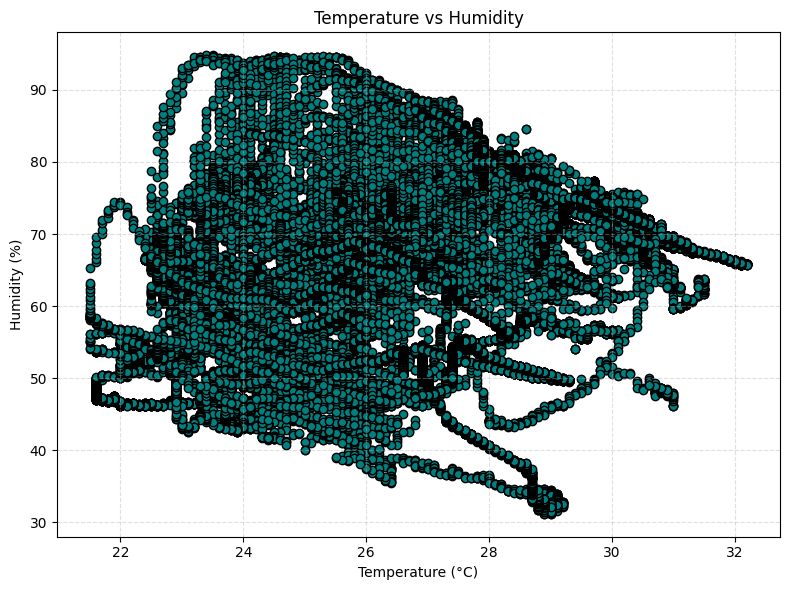

In [127]:
plot_temperature_vs_humidity(df,temp_col='temperature',humid_col='humidity',figsize=(8,6),color='teal',edgecolors='black')


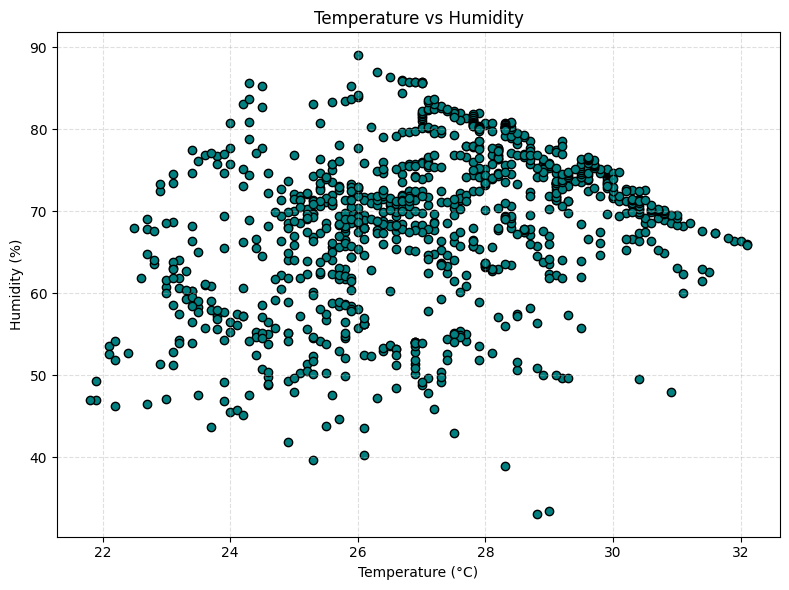

In [128]:
plot_temperature_vs_humidity(hourly,temp_col='temperature',humid_col='humidity',figsize=(8,6),color='teal',edgecolors='black')

In [129]:
def get_distribution_type(data: pd.DataFrame, feature: str, **kwargs):
    """
    Plot the distribution of a given feature using seaborn.displot.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the feature.
    feature : str
        Column name to plot.
    **kwargs :
        Additional keyword arguments passed to sns.displot().
    """
    try:
        sns.displot(data[feature], **kwargs)
        plt.show()
    except Exception as e:
        print(f"Error plotting feature '{feature}': {e}")
        raise
def check_outliers(data: pd.DataFrame, feature: str, **kwargs):
    """
    Visualize outliers for a given feature using a Seaborn boxplot.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the feature.
    feature : str
        The column name to visualize for outliers.
    **kwargs :
        Additional keyword arguments to customize seaborn.boxplot().
        Examples: color='skyblue', orient='v', width=0.5, showcaps=False
    """
    try:
        plt.figure(figsize=kwargs.pop('figsize', (6, 3)))  # optional figure size
        sns.boxplot(data=data, x=feature, **kwargs)
        plt.title(f"Outlier Check: {feature}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting feature '{feature}': {e}")
        raise

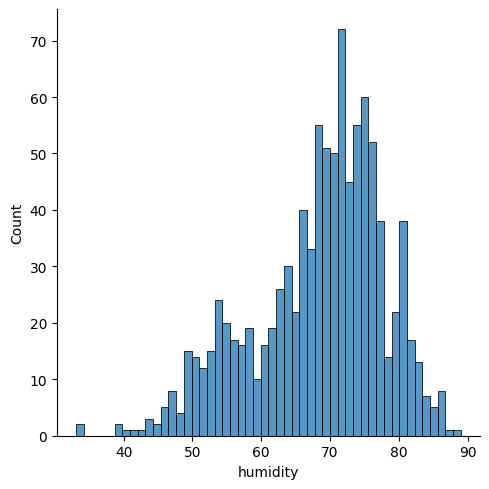

In [130]:
get_distribution_type(data=hourly, feature='humidity', bins=50)

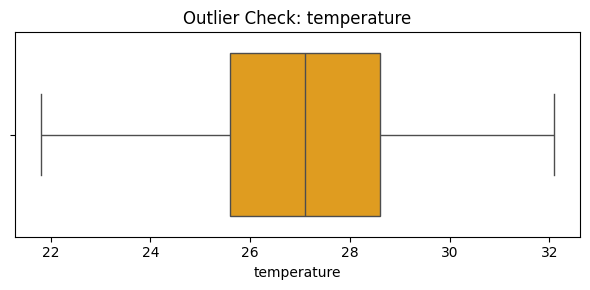

In [131]:
check_outliers(data=hourly, feature='temperature', color='orange')

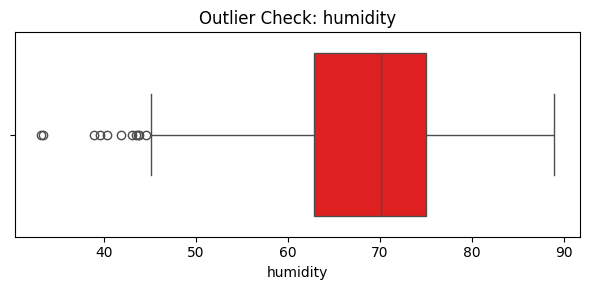

In [132]:
check_outliers(data=hourly, feature='humidity',color='red')

In [133]:
outliers_data = len(np.where(hourly['humidity'] < 50)[0])
data_length = len(hourly.index)

In [134]:
outliers_data

45

In [135]:
(outliers_data / data_length) * 100

4.587155963302752

In [136]:
hourly.corr(numeric_only=True)

,humidity,temperature,hour,Temp_MA_2,Humidity_MA_2,Temp_rate,Humidity_rate,Temp_group,Humidity_group
humidity,1.000000,0.311894,-0.048483,0.300957,0.986313,0.095439,0.251935,-0.663365,-0.656790
temperature,0.311894,1.000000,-0.114528,0.987570,0.324669,0.247807,-0.019746,-0.310696,-0.298887
hour,-0.048483,-0.114528,1.000000,-0.119323,-0.059863,0.005923,0.126520,0.011922,0.011957
Temp_MA_2,0.300957,0.987570,-0.119323,1.000000,0.316591,0.126401,-0.055266,-0.314541,-0.302542
Humidity_MA_2,0.986313,0.324669,-0.059863,0.316591,1.000000,0.098213,0.135256,-0.671515,-0.664886
Temp_rate,0.095439,0.247807,0.005923,0.126401,0.098213,1.000000,0.136565,-0.005399,-0.005578
Humidity_rate,0.251935,-0.019746,0.126520,-0.055266,0.135256,0.136565,1.000000,-0.012519,-0.011983
Temp_group,-0.663365,-0.310696,0.011922,-0.314541,-0.671515,-0.005399,-0.012519,1.000000,0.999083
Humidity_group,-0.656790,-0.298887,0.011957,-0.302542,-0.664886,-0.005578,-0.011983,0.999083,1.000000
